<a href="https://colab.research.google.com/github/quaneh/fnma-predictor/blob/main/fnma_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup & Imports
* We need to download Optuna for hyperparameter tuning

In [2]:
!pip install --quiet optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.1 MB/s eta 0:00:00


In [3]:
import optuna

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, mean_squared_error, accuracy_score

import xgboost as xgb

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

## Load and Process Data

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/quaneh/fnma-predictor/main/data/fnma_2007q4_semi_processed.csv', index_col=0)

Remove columns that will not contribute to our model

In [5]:
drop_cols = ['LOAN_ID','PPMT_FLG', 'IO', 'Zero_Bal_Code', 'ZB_DTE', 'LAST_UPB','RE_PROCS_FLAG', 'PRODUCT', 'HOMEREADY_PROGRAM_INDICATOR', 'HIGH_BALANCE_LOAN_INDICATOR',
             'HIGH_LOAN_TO_VALUE_HLTV_REFINANCE_OPTION_INDICATOR', ]
df = df.drop(drop_cols, axis=1)

Remove further columns that could not be known before the loan is approved or disapproved.

Delinquency status can only be know for a loan that has been approved and is now being repaid, and the same applies for Current Unpaid Balance.

In [6]:
drop_cols = ['DLQ_STATUS', 'CURRENT_UPB']
df = df.drop(drop_cols, axis=1)

In [7]:
df

,ACT_PERIOD,CHANNEL,SELLER,ORIG_RATE,ORIG_UPB,ORIG_TERM,ORIG_DATE,FIRST_PAY,OLTV,OCLTV,...,FIRST_FLAG,PURPOSE,PROP,NO_UNITS,OCC_STAT,STATE,MSA,ZIP,RELOCATION_MORTGAGE_INDICATOR,HAS_DEFAULTED
0,12009,C,"Bank Of America, N.A.",6.625,343000.0,360,102007,122007,86,86.0,...,N,C,PU,1,P,CO,17820,809.0,N,0
1,82013,C,"Bank Of America, N.A.",6.250,400000.0,360,102007,122007,62,62.0,...,N,P,SF,1,P,CA,41740,920.0,N,0
2,102021,B,Other,6.625,81000.0,360,112007,12008,64,82.0,...,N,R,SF,1,P,LA,12940,708.0,N,0
3,122015,B,Amtrust Bank,6.500,119000.0,360,112007,12008,71,71.0,...,N,R,CO,1,P,IL,16980,600.0,N,0
4,62019,B,"Bank Of America, N.A.",6.625,205000.0,360,102007,122007,27,27.0,...,N,C,SF,1,P,CA,31080,907.0,N,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391178,52008,R,Other,6.500,139000.0,360,112007,12008,58,58.0,...,N,P,PU,1,P,MO,28140,641.0,N,0
391179,62009,R,Other,6.375,47000.0,180,12007,32007,76,76.0,...,N,R,SF,1,P,OH,17460,441.0,N,0
391180,22015,C,"Citimortgage, Inc.",6.125,135000.0,360,112007,12008,56,56.0,...,N,P,CO,1,I,CA,37100,913.0,N,0
391181,12010,B,"Bank Of America, N.A.",6.250,344000.0,360,112007,12008,80,80.0,...,N,C,SF,1,P,PA,0,155.0,N,0


Split dates into month and year.

In [8]:
df['ACT_PERIOD_YEAR'] = df['ACT_PERIOD'].apply(lambda x: str(x)[-4:]).astype(int)
df['ACT_PERIOD_MONTH'] = df['ACT_PERIOD'].apply(lambda x: str(x)[:-4]).astype(int)
df = df.drop(['ACT_PERIOD'], axis=1)

In [9]:
df['ORIG_DATE_YEAR'] = df['ORIG_DATE'].apply(lambda x: str(x)[-4:]).astype(int)
df['ORIG_DATE_MONTH'] = df['ORIG_DATE'].apply(lambda x: str(x)[:-4]).astype(int)
df = df.drop(['ORIG_DATE'], axis=1)

In [10]:
df['FIRST_PAY_YEAR'] = df['FIRST_PAY'].apply(lambda x: str(x)[-4:]).astype(int)
df['FIRST_PAY_MONTH'] = df['FIRST_PAY'].apply(lambda x: str(x)[:-4]).astype(int)
df = df.drop(['FIRST_PAY'], axis=1)

Replace whitespace in SELLER values and make lowercase

In [11]:
df['SELLER'].replace(' ', '_', regex=True, inplace=True)
df['SELLER'].replace('\.', '', regex=True, inplace=True)
df['SELLER'].replace('\,', '', regex=True, inplace=True)
df['SELLER'] = df['SELLER'].str.lower()


Get Latitude and Longitude for each ZIP code so that we can use numeric values.

Areas that are close together will have Lat/Long values that are also close together. It's possible that certain regions have higher rates of default than others.

In [12]:
zip_code_map = pd.read_csv('https://raw.githubusercontent.com/quaneh/fnma-predictor/main/data/zip_lat_long.csv', sep=',', header=0,
                           names=['ZIP', 'LAT', 'LONG'], dtype={'ZIP': str})

zip_code_map['ZIP'] = zip_code_map['ZIP'].apply(lambda x: x[:3])

zip_code_map = zip_code_map.groupby('ZIP')[['LAT', 'LONG']].mean().reset_index()

df['ZIP'] = df['ZIP'].astype(int).astype(str).str.zfill(3)

df = df.merge(zip_code_map, on='ZIP', how='left')

df.drop(['ZIP', 'STATE', 'MSA'], axis=1, inplace=True)

### Replace Null Values

Note: Here we replace all null values with 0 as we have decided on XGBoost as our chosen model. We also experimented with imputed values.

In [13]:
df['DTI'].fillna(0, inplace=True)
df['CSCORE_B'].fillna(0, inplace=True)
df['CSCORE_C'].fillna(0, inplace=True)
df['FIRST_FLAG'].fillna('XX', inplace=True)
df['NUM_BO'].fillna(0, inplace=True)
df['OCLTV'].fillna(0, inplace=True)
df['LAT'].fillna(0, inplace=True)
df['LONG'].fillna(0, inplace=True)

In [14]:
df = df[df['ORIG_RATE'].notnull()]

In [15]:
df.dtypes

CHANNEL                           object
SELLER                            object
ORIG_RATE                        float64
ORIG_UPB                         float64
ORIG_TERM                          int64
OLTV                               int64
OCLTV                            float64
NUM_BO                           float64
DTI                              float64
CSCORE_B                         float64
CSCORE_C                         float64
FIRST_FLAG                        object
PURPOSE                           object
PROP                              object
NO_UNITS                           int64
OCC_STAT                          object
RELOCATION_MORTGAGE_INDICATOR     object
HAS_DEFAULTED                      int64
ACT_PERIOD_YEAR                    int64
ACT_PERIOD_MONTH                   int64
ORIG_DATE_YEAR                     int64
ORIG_DATE_MONTH                    int64
FIRST_PAY_YEAR                     int64
FIRST_PAY_MONTH                    int64
LAT             

We can use the following visualisation for exploring our dataset.

Change the *column* to view how default rates vary for different values for that feature.

Text(0, 0.5, 'NUM_BO')

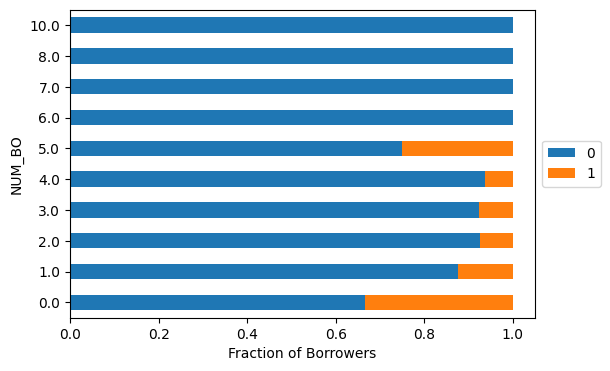

In [16]:
column = 'NUM_BO'

data = df.loc[df[column].isin(df[column].value_counts().index.tolist()[:10])]

xtab = pd.pivot_table(data, index=column, columns='HAS_DEFAULTED', aggfunc='size')
xtab = xtab.div(xtab.sum(axis=1), axis=0)
xtab.plot.barh(stacked=True, figsize=(6,4))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('Fraction of Borrowers')
plt.ylabel(column)

### Processing

* Here we split our dataset into X and y (predictor variables and target variable)

* We check that we no longer have any null values in our dataset.

* We then convert the non-numerical data to the category type

In [17]:
y = df['HAS_DEFAULTED'].copy()
X = df.drop(['HAS_DEFAULTED'], axis=1).copy()

In [18]:
X.columns = map(str.lower, X.columns)
X.iloc[0].to_json()

'{"channel":"C","seller":"bank_of_america_na","orig_rate":6.625,"orig_upb":343000.0,"orig_term":360,"oltv":86,"ocltv":86.0,"num_bo":2.0,"dti":27.0,"cscore_b":751.0,"cscore_c":756.0,"first_flag":"N","purpose":"C","prop":"PU","no_units":1,"occ_stat":"P","relocation_mortgage_indicator":"N","act_period_year":2009,"act_period_month":1,"orig_date_year":2007,"orig_date_month":10,"first_pay_year":2007,"first_pay_month":12,"lat":38.8454972258,"long":-104.7358872258}'

In [19]:
X.apply(lambda x: x.isnull().sum(), axis=0)

channel                          0
seller                           0
orig_rate                        0
orig_upb                         0
orig_term                        0
oltv                             0
ocltv                            0
num_bo                           0
dti                              0
cscore_b                         0
cscore_c                         0
first_flag                       0
purpose                          0
prop                             0
no_units                         0
occ_stat                         0
relocation_mortgage_indicator    0
act_period_year                  0
act_period_month                 0
orig_date_year                   0
orig_date_month                  0
first_pay_year                   0
first_pay_month                  0
lat                              0
long                             0
dtype: int64

In [20]:
# Extract text features
cats = X.select_dtypes(exclude=np.number).columns.tolist()

# Convert to Pandas category
for col in cats:
   X[col] = X[col].astype('category')

### Split into Train and Test

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

dtrain = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [22]:
sum(y_train)/len(y_train)

0.09840312217734376

In [23]:
sum(y_test)/len(y_test)

0.09840993915844368

## Hyperparameter Tuning OPTUNA

Here we'll set up our hyperparameter tuning experiment with Optuna
With optuna we define our objective, then initialise the study for a set number of trials, and our final output provides us the detail of the best trial.

When defining our objective we set the ranges for each of the variable input parameters for our model.

We also set some constant input paramenters for the model.

The most important part of defining the objective is setting the objective variable. In this case we decide to maximise the AUC-PR value.

In [25]:
def objective(trial):
    params = {"objective":"binary:logistic","tree_method": "hist", "device": "gpu", "eval_metric": "aucpr",
              'max_depth': trial.suggest_int('max_depth', 3, 18),
              'gamma': trial.suggest_float('gamma', 1, 9),
              'reg_alpha': trial.suggest_int('reg_alpha', 40, 180),
              'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
              'min_child_weight': trial.suggest_int('min_child_weight', 0, 10),
              'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
              'scale_pos_weight': trial.suggest_int('scale_pos_weight', 1, 13)}

    evals = [(dtrain, "train"), (dtest, "validation")]

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=5000,
        evals=evals,
        verbose_eval=False,
        early_stopping_rounds=100,
        )

    print ("SCORE:", model.best_score)
    return model.best_score

In [26]:
%timeit

study = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.INFO)
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('Score: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2024-03-15 03:21:56,089] A new study created in memory with name: no-name-a52073fe-bf33-4dfe-8b6b-4106b262c9eb
[I 2024-03-15 03:21:57,850] Trial 0 finished with value: 0.508060382921804 and parameters: {'max_depth': 5, 'gamma': 5.112641887186764, 'reg_alpha': 110, 'reg_lambda': 0.6540393918644345, 'min_child_weight': 9, 'colsample_bytree': 0.5780111509777641, 'scale_pos_weight': 8}. Best is trial 0 with value: 0.508060382921804.


SCORE: 0.508060382921804


[I 2024-03-15 03:21:58,880] Trial 1 finished with value: 0.5126943694118078 and parameters: {'max_depth': 6, 'gamma': 7.734264873955768, 'reg_alpha': 144, 'reg_lambda': 0.6621776629802607, 'min_child_weight': 8, 'colsample_bytree': 0.9225589453865888, 'scale_pos_weight': 12}. Best is trial 1 with value: 0.5126943694118078.


SCORE: 0.5126943694118078


[I 2024-03-15 03:22:00,413] Trial 2 finished with value: 0.5155393985173489 and parameters: {'max_depth': 4, 'gamma': 4.348338997030887, 'reg_alpha': 45, 'reg_lambda': 0.2316575396512469, 'min_child_weight': 6, 'colsample_bytree': 0.8114495480135244, 'scale_pos_weight': 12}. Best is trial 2 with value: 0.5155393985173489.


SCORE: 0.5155393985173489


[I 2024-03-15 03:22:01,597] Trial 3 finished with value: 0.5265605090554513 and parameters: {'max_depth': 11, 'gamma': 6.069826034076737, 'reg_alpha': 94, 'reg_lambda': 0.46769199018448104, 'min_child_weight': 10, 'colsample_bytree': 0.6325737814827983, 'scale_pos_weight': 9}. Best is trial 3 with value: 0.5265605090554513.


SCORE: 0.5265605090554513


[I 2024-03-15 03:22:03,645] Trial 4 finished with value: 0.527209489210099 and parameters: {'max_depth': 17, 'gamma': 2.6848951094254403, 'reg_alpha': 104, 'reg_lambda': 0.25715337164513896, 'min_child_weight': 8, 'colsample_bytree': 0.9333550223058558, 'scale_pos_weight': 12}. Best is trial 4 with value: 0.527209489210099.


SCORE: 0.527209489210099


[I 2024-03-15 03:22:04,804] Trial 5 finished with value: 0.5032148623603804 and parameters: {'max_depth': 15, 'gamma': 2.6763168933478285, 'reg_alpha': 73, 'reg_lambda': 0.16849937284863103, 'min_child_weight': 6, 'colsample_bytree': 0.5545637362569458, 'scale_pos_weight': 1}. Best is trial 4 with value: 0.527209489210099.


SCORE: 0.5032148623603804


[I 2024-03-15 03:22:06,927] Trial 6 finished with value: 0.5294495663006362 and parameters: {'max_depth': 15, 'gamma': 1.9251943747161269, 'reg_alpha': 110, 'reg_lambda': 0.7915619882360597, 'min_child_weight': 1, 'colsample_bytree': 0.8884487053736033, 'scale_pos_weight': 13}. Best is trial 6 with value: 0.5294495663006362.


SCORE: 0.5294495663006362


[I 2024-03-15 03:22:07,945] Trial 7 finished with value: 0.5204312393100534 and parameters: {'max_depth': 9, 'gamma': 8.696979306266154, 'reg_alpha': 50, 'reg_lambda': 0.40351949952395005, 'min_child_weight': 6, 'colsample_bytree': 0.746423337524347, 'scale_pos_weight': 5}. Best is trial 6 with value: 0.5294495663006362.


SCORE: 0.5204312393100534


[I 2024-03-15 03:22:08,912] Trial 8 finished with value: 0.49838436008630627 and parameters: {'max_depth': 13, 'gamma': 7.371097810628985, 'reg_alpha': 59, 'reg_lambda': 0.8848811112697501, 'min_child_weight': 7, 'colsample_bytree': 0.9175187340352393, 'scale_pos_weight': 1}. Best is trial 6 with value: 0.5294495663006362.


SCORE: 0.49838436008630627


[I 2024-03-15 03:22:10,453] Trial 9 finished with value: 0.5253104736403177 and parameters: {'max_depth': 11, 'gamma': 4.629570239801517, 'reg_alpha': 85, 'reg_lambda': 0.732657872007637, 'min_child_weight': 6, 'colsample_bytree': 0.6109550488855664, 'scale_pos_weight': 12}. Best is trial 6 with value: 0.5294495663006362.


SCORE: 0.5253104736403177


[I 2024-03-15 03:22:12,052] Trial 10 finished with value: 0.5207585908622392 and parameters: {'max_depth': 18, 'gamma': 1.505551206265393, 'reg_alpha': 142, 'reg_lambda': 0.9996458013540038, 'min_child_weight': 0, 'colsample_bytree': 0.8072928470721024, 'scale_pos_weight': 5}. Best is trial 6 with value: 0.5294495663006362.


SCORE: 0.5207585908622392


[I 2024-03-15 03:22:13,980] Trial 11 finished with value: 0.5256910628078947 and parameters: {'max_depth': 18, 'gamma': 2.6558785489307537, 'reg_alpha': 172, 'reg_lambda': 0.053957820192174766, 'min_child_weight': 2, 'colsample_bytree': 0.9797952716238083, 'scale_pos_weight': 13}. Best is trial 6 with value: 0.5294495663006362.


SCORE: 0.5256910628078947


[I 2024-03-15 03:22:16,308] Trial 12 finished with value: 0.5262810275022536 and parameters: {'max_depth': 15, 'gamma': 1.4509417426572542, 'reg_alpha': 127, 'reg_lambda': 0.29997142935975335, 'min_child_weight': 3, 'colsample_bytree': 0.8714881641324392, 'scale_pos_weight': 10}. Best is trial 6 with value: 0.5294495663006362.


SCORE: 0.5262810275022536


[I 2024-03-15 03:22:17,996] Trial 13 finished with value: 0.5262465869419596 and parameters: {'max_depth': 16, 'gamma': 3.125637930029745, 'reg_alpha': 113, 'reg_lambda': 0.5182650412207724, 'min_child_weight': 3, 'colsample_bytree': 0.995701997056655, 'scale_pos_weight': 10}. Best is trial 6 with value: 0.5294495663006362.


SCORE: 0.5262465869419596


[I 2024-03-15 03:22:19,377] Trial 14 finished with value: 0.5252609123310898 and parameters: {'max_depth': 13, 'gamma': 3.2651444472516875, 'reg_alpha': 105, 'reg_lambda': 0.8112371532611279, 'min_child_weight': 1, 'colsample_bytree': 0.7467503225659724, 'scale_pos_weight': 6}. Best is trial 6 with value: 0.5294495663006362.


SCORE: 0.5252609123310898


[I 2024-03-15 03:22:21,774] Trial 15 finished with value: 0.527669257242284 and parameters: {'max_depth': 16, 'gamma': 1.2010151013190704, 'reg_alpha': 128, 'reg_lambda': 0.07493036030524125, 'min_child_weight': 4, 'colsample_bytree': 0.8442814783118885, 'scale_pos_weight': 13}. Best is trial 6 with value: 0.5294495663006362.


SCORE: 0.527669257242284


[I 2024-03-15 03:22:23,749] Trial 16 finished with value: 0.5300524948139637 and parameters: {'max_depth': 13, 'gamma': 1.1336561120222655, 'reg_alpha': 167, 'reg_lambda': 0.09709732702260876, 'min_child_weight': 4, 'colsample_bytree': 0.6949040601080642, 'scale_pos_weight': 10}. Best is trial 16 with value: 0.5300524948139637.


SCORE: 0.5300524948139637


[I 2024-03-15 03:22:25,140] Trial 17 finished with value: 0.5257602782321156 and parameters: {'max_depth': 8, 'gamma': 1.0101538039296158, 'reg_alpha': 180, 'reg_lambda': 0.5385119766242408, 'min_child_weight': 0, 'colsample_bytree': 0.6939905839571546, 'scale_pos_weight': 10}. Best is trial 16 with value: 0.5300524948139637.


SCORE: 0.5257602782321156


[I 2024-03-15 03:22:26,697] Trial 18 finished with value: 0.518803068974849 and parameters: {'max_depth': 13, 'gamma': 1.9932177457174916, 'reg_alpha': 161, 'reg_lambda': 0.9280927395217882, 'min_child_weight': 4, 'colsample_bytree': 0.5090913126542858, 'scale_pos_weight': 8}. Best is trial 16 with value: 0.5300524948139637.


SCORE: 0.518803068974849


[I 2024-03-15 03:22:28,457] Trial 19 finished with value: 0.5247229396084943 and parameters: {'max_depth': 14, 'gamma': 3.9622211211955443, 'reg_alpha': 155, 'reg_lambda': 0.0009515758158526316, 'min_child_weight': 2, 'colsample_bytree': 0.6921494468945574, 'scale_pos_weight': 11}. Best is trial 16 with value: 0.5300524948139637.


SCORE: 0.5247229396084943


[I 2024-03-15 03:22:29,565] Trial 20 finished with value: 0.5183493060638218 and parameters: {'max_depth': 9, 'gamma': 5.940089022443797, 'reg_alpha': 125, 'reg_lambda': 0.40005400463227997, 'min_child_weight': 4, 'colsample_bytree': 0.687964502823107, 'scale_pos_weight': 8}. Best is trial 16 with value: 0.5300524948139637.


SCORE: 0.5183493060638218


[I 2024-03-15 03:22:31,622] Trial 21 finished with value: 0.5269014078730813 and parameters: {'max_depth': 16, 'gamma': 1.9378669331785603, 'reg_alpha': 127, 'reg_lambda': 0.11846386817002941, 'min_child_weight': 4, 'colsample_bytree': 0.831717940761564, 'scale_pos_weight': 13}. Best is trial 16 with value: 0.5300524948139637.


SCORE: 0.5269014078730813


[I 2024-03-15 03:22:33,526] Trial 22 finished with value: 0.5307387495380057 and parameters: {'max_depth': 12, 'gamma': 1.2808200982003757, 'reg_alpha': 143, 'reg_lambda': 0.1765675168106381, 'min_child_weight': 2, 'colsample_bytree': 0.8579083223399264, 'scale_pos_weight': 13}. Best is trial 22 with value: 0.5307387495380057.


SCORE: 0.5307387495380057


[I 2024-03-15 03:22:35,066] Trial 23 finished with value: 0.5270464591504725 and parameters: {'max_depth': 12, 'gamma': 1.9496853289131328, 'reg_alpha': 149, 'reg_lambda': 0.16774941662969506, 'min_child_weight': 1, 'colsample_bytree': 0.7910367119192275, 'scale_pos_weight': 11}. Best is trial 22 with value: 0.5307387495380057.


SCORE: 0.5270464591504725


[I 2024-03-15 03:22:36,350] Trial 24 finished with value: 0.5231756053244739 and parameters: {'max_depth': 10, 'gamma': 3.548992848232569, 'reg_alpha': 165, 'reg_lambda': 0.3004409115003169, 'min_child_weight': 2, 'colsample_bytree': 0.8816492071801171, 'scale_pos_weight': 11}. Best is trial 22 with value: 0.5307387495380057.


SCORE: 0.5231756053244739


[I 2024-03-15 03:22:37,586] Trial 25 finished with value: 0.5105675640136239 and parameters: {'max_depth': 14, 'gamma': 2.2415542001866893, 'reg_alpha': 135, 'reg_lambda': 0.6062177949805054, 'min_child_weight': 1, 'colsample_bytree': 0.7692843120067063, 'scale_pos_weight': 3}. Best is trial 22 with value: 0.5307387495380057.


SCORE: 0.5105675640136239


[I 2024-03-15 03:22:39,508] Trial 26 finished with value: 0.5270411274189778 and parameters: {'max_depth': 12, 'gamma': 1.0196510353625268, 'reg_alpha': 169, 'reg_lambda': 0.7803694319572437, 'min_child_weight': 3, 'colsample_bytree': 0.8843168083024326, 'scale_pos_weight': 9}. Best is trial 22 with value: 0.5307387495380057.


SCORE: 0.5270411274189778


[I 2024-03-15 03:22:40,970] Trial 27 finished with value: 0.5253912483568297 and parameters: {'max_depth': 7, 'gamma': 1.6952593693626081, 'reg_alpha': 151, 'reg_lambda': 0.38151025403768307, 'min_child_weight': 5, 'colsample_bytree': 0.9553999077339836, 'scale_pos_weight': 13}. Best is trial 22 with value: 0.5307387495380057.


SCORE: 0.5253912483568297


[I 2024-03-15 03:22:42,484] Trial 28 finished with value: 0.5213137213603171 and parameters: {'max_depth': 14, 'gamma': 2.3383728220855136, 'reg_alpha': 180, 'reg_lambda': 0.1978684947814352, 'min_child_weight': 0, 'colsample_bytree': 0.7152475323777301, 'scale_pos_weight': 11}. Best is trial 22 with value: 0.5307387495380057.


SCORE: 0.5213137213603171


[I 2024-03-15 03:22:43,678] Trial 29 finished with value: 0.5199628885740455 and parameters: {'max_depth': 12, 'gamma': 5.501847882022194, 'reg_alpha': 117, 'reg_lambda': 0.6392135524275706, 'min_child_weight': 2, 'colsample_bytree': 0.6445849204630479, 'scale_pos_weight': 7}. Best is trial 22 with value: 0.5307387495380057.


SCORE: 0.5199628885740455


[I 2024-03-15 03:22:44,995] Trial 30 finished with value: 0.5249160291450647 and parameters: {'max_depth': 10, 'gamma': 3.8265807172765904, 'reg_alpha': 91, 'reg_lambda': 0.0038737206592908136, 'min_child_weight': 5, 'colsample_bytree': 0.8456352953491484, 'scale_pos_weight': 9}. Best is trial 22 with value: 0.5307387495380057.


SCORE: 0.5249160291450647


[I 2024-03-15 03:22:47,439] Trial 31 finished with value: 0.5239406806617019 and parameters: {'max_depth': 16, 'gamma': 1.005852769745947, 'reg_alpha': 135, 'reg_lambda': 0.09300484517730118, 'min_child_weight': 3, 'colsample_bytree': 0.8470188948038561, 'scale_pos_weight': 13}. Best is trial 22 with value: 0.5307387495380057.


SCORE: 0.5239406806617019


[I 2024-03-15 03:22:49,598] Trial 32 finished with value: 0.5301438509204294 and parameters: {'max_depth': 15, 'gamma': 1.4968227217214867, 'reg_alpha': 139, 'reg_lambda': 0.11650795666638511, 'min_child_weight': 4, 'colsample_bytree': 0.905564869295568, 'scale_pos_weight': 13}. Best is trial 22 with value: 0.5307387495380057.


SCORE: 0.5301438509204294


[I 2024-03-15 03:22:51,744] Trial 33 finished with value: 0.5255877594824101 and parameters: {'max_depth': 15, 'gamma': 1.6131506356181085, 'reg_alpha': 141, 'reg_lambda': 0.1173389030811576, 'min_child_weight': 1, 'colsample_bytree': 0.9060538487632842, 'scale_pos_weight': 12}. Best is trial 22 with value: 0.5307387495380057.


SCORE: 0.5255877594824101


[I 2024-03-15 03:22:53,494] Trial 34 finished with value: 0.49618073193676465 and parameters: {'max_depth': 3, 'gamma': 2.396770793192948, 'reg_alpha': 156, 'reg_lambda': 0.3126652991809974, 'min_child_weight': 3, 'colsample_bytree': 0.9588397657530078, 'scale_pos_weight': 12}. Best is trial 22 with value: 0.5307387495380057.


SCORE: 0.49618073193676465


[I 2024-03-15 03:22:55,200] Trial 35 finished with value: 0.5265409043506448 and parameters: {'max_depth': 17, 'gamma': 3.0698938156564908, 'reg_alpha': 115, 'reg_lambda': 0.17032062291063824, 'min_child_weight': 5, 'colsample_bytree': 0.9364645825758307, 'scale_pos_weight': 11}. Best is trial 22 with value: 0.5307387495380057.


SCORE: 0.5265409043506448


[I 2024-03-15 03:22:56,576] Trial 36 finished with value: 0.5257853223920597 and parameters: {'max_depth': 14, 'gamma': 6.849631073050896, 'reg_alpha': 100, 'reg_lambda': 0.24687179768222015, 'min_child_weight': 2, 'colsample_bytree': 0.7797717247070143, 'scale_pos_weight': 13}. Best is trial 22 with value: 0.5307387495380057.


SCORE: 0.5257853223920597


[I 2024-03-15 03:22:58,477] Trial 37 finished with value: 0.5297595208879158 and parameters: {'max_depth': 12, 'gamma': 1.530334932322723, 'reg_alpha': 136, 'reg_lambda': 0.470970916540505, 'min_child_weight': 10, 'colsample_bytree': 0.8983419848162529, 'scale_pos_weight': 12}. Best is trial 22 with value: 0.5307387495380057.


SCORE: 0.5297595208879158


[I 2024-03-15 03:23:00,046] Trial 38 finished with value: 0.5278058069313932 and parameters: {'max_depth': 11, 'gamma': 1.4368102018744826, 'reg_alpha': 145, 'reg_lambda': 0.44105565204511693, 'min_child_weight': 10, 'colsample_bytree': 0.8206426864890057, 'scale_pos_weight': 12}. Best is trial 22 with value: 0.5307387495380057.


SCORE: 0.5278058069313932


[I 2024-03-15 03:23:01,460] Trial 39 finished with value: 0.5233966219582111 and parameters: {'max_depth': 12, 'gamma': 2.861683520479652, 'reg_alpha': 159, 'reg_lambda': 0.2083553996881562, 'min_child_weight': 9, 'colsample_bytree': 0.9068325544886867, 'scale_pos_weight': 10}. Best is trial 22 with value: 0.5307387495380057.


SCORE: 0.5233966219582111


[I 2024-03-15 03:23:02,601] Trial 40 finished with value: 0.509237716718976 and parameters: {'max_depth': 6, 'gamma': 8.455725575799821, 'reg_alpha': 137, 'reg_lambda': 0.32688587150616194, 'min_child_weight': 7, 'colsample_bytree': 0.6589329314057183, 'scale_pos_weight': 9}. Best is trial 22 with value: 0.5307387495380057.


SCORE: 0.509237716718976


[I 2024-03-15 03:23:04,761] Trial 41 finished with value: 0.5273667866742467 and parameters: {'max_depth': 13, 'gamma': 1.8321088994890573, 'reg_alpha': 121, 'reg_lambda': 0.13680031810320198, 'min_child_weight': 9, 'colsample_bytree': 0.867722170893815, 'scale_pos_weight': 12}. Best is trial 22 with value: 0.5307387495380057.


SCORE: 0.5273667866742467


[I 2024-03-15 03:23:06,780] Trial 42 finished with value: 0.5287169957464578 and parameters: {'max_depth': 15, 'gamma': 2.4007651651812605, 'reg_alpha': 109, 'reg_lambda': 0.7123920194329851, 'min_child_weight': 7, 'colsample_bytree': 0.9376861036656957, 'scale_pos_weight': 13}. Best is trial 22 with value: 0.5307387495380057.


SCORE: 0.5287169957464578


[I 2024-03-15 03:23:08,767] Trial 43 finished with value: 0.530279263161466 and parameters: {'max_depth': 11, 'gamma': 1.4087756611094808, 'reg_alpha': 76, 'reg_lambda': 0.5933184545615033, 'min_child_weight': 6, 'colsample_bytree': 0.9008623530059582, 'scale_pos_weight': 12}. Best is trial 22 with value: 0.5307387495380057.


SCORE: 0.530279263161466


[I 2024-03-15 03:23:10,659] Trial 44 finished with value: 0.5291400063055254 and parameters: {'max_depth': 10, 'gamma': 1.459932463007375, 'reg_alpha': 73, 'reg_lambda': 0.5938074189670012, 'min_child_weight': 8, 'colsample_bytree': 0.5857560208395935, 'scale_pos_weight': 12}. Best is trial 22 with value: 0.5307387495380057.


SCORE: 0.5291400063055254


[I 2024-03-15 03:23:12,054] Trial 45 finished with value: 0.527373829006709 and parameters: {'max_depth': 11, 'gamma': 4.798580389709707, 'reg_alpha': 47, 'reg_lambda': 0.04505959222774208, 'min_child_weight': 6, 'colsample_bytree': 0.9064194970809853, 'scale_pos_weight': 12}. Best is trial 22 with value: 0.5307387495380057.


SCORE: 0.527373829006709


[I 2024-03-15 03:23:13,857] Trial 46 finished with value: 0.5284488387030739 and parameters: {'max_depth': 13, 'gamma': 1.3238836116641963, 'reg_alpha': 149, 'reg_lambda': 0.5640076862251576, 'min_child_weight': 8, 'colsample_bytree': 0.9603329921124024, 'scale_pos_weight': 11}. Best is trial 22 with value: 0.5307387495380057.


SCORE: 0.5284488387030739


[I 2024-03-15 03:23:15,482] Trial 47 finished with value: 0.5294737248484731 and parameters: {'max_depth': 9, 'gamma': 2.13805639120842, 'reg_alpha': 71, 'reg_lambda': 0.473130838984289, 'min_child_weight': 9, 'colsample_bytree': 0.8661180703679356, 'scale_pos_weight': 10}. Best is trial 22 with value: 0.5307387495380057.


SCORE: 0.5294737248484731


[I 2024-03-15 03:23:17,420] Trial 48 finished with value: 0.5321287988621185 and parameters: {'max_depth': 11, 'gamma': 2.6624431004361915, 'reg_alpha': 63, 'reg_lambda': 0.2614680806129741, 'min_child_weight': 4, 'colsample_bytree': 0.7263977908365312, 'scale_pos_weight': 12}. Best is trial 48 with value: 0.5321287988621185.


SCORE: 0.5321287988621185


[I 2024-03-15 03:23:19,286] Trial 49 finished with value: 0.5317345448402551 and parameters: {'max_depth': 11, 'gamma': 2.814332532564918, 'reg_alpha': 59, 'reg_lambda': 0.25044290326819163, 'min_child_weight': 4, 'colsample_bytree': 0.7125810860899405, 'scale_pos_weight': 11}. Best is trial 48 with value: 0.5321287988621185.


SCORE: 0.5317345448402551


[I 2024-03-15 03:23:20,677] Trial 50 finished with value: 0.5288886634581612 and parameters: {'max_depth': 8, 'gamma': 2.692981547026553, 'reg_alpha': 62, 'reg_lambda': 0.24432246882251163, 'min_child_weight': 5, 'colsample_bytree': 0.716137234973899, 'scale_pos_weight': 13}. Best is trial 48 with value: 0.5321287988621185.


SCORE: 0.5288886634581612


[I 2024-03-15 03:23:22,231] Trial 51 finished with value: 0.5272350439050391 and parameters: {'max_depth': 11, 'gamma': 3.334916544155677, 'reg_alpha': 65, 'reg_lambda': 0.27568726604099286, 'min_child_weight': 4, 'colsample_bytree': 0.7271101574060074, 'scale_pos_weight': 11}. Best is trial 48 with value: 0.5321287988621185.


SCORE: 0.5272350439050391


[I 2024-03-15 03:23:23,724] Trial 52 finished with value: 0.5310655863269272 and parameters: {'max_depth': 10, 'gamma': 4.1862586273187485, 'reg_alpha': 58, 'reg_lambda': 0.34598484894721754, 'min_child_weight': 6, 'colsample_bytree': 0.6708131703400343, 'scale_pos_weight': 12}. Best is trial 48 with value: 0.5321287988621185.


SCORE: 0.5310655863269272


[I 2024-03-15 03:23:25,209] Trial 53 finished with value: 0.5301778853862885 and parameters: {'max_depth': 10, 'gamma': 4.188351049039053, 'reg_alpha': 54, 'reg_lambda': 0.20737131085753047, 'min_child_weight': 6, 'colsample_bytree': 0.6591952158612231, 'scale_pos_weight': 12}. Best is trial 48 with value: 0.5321287988621185.


SCORE: 0.5301778853862885


[I 2024-03-15 03:23:26,652] Trial 54 finished with value: 0.528383778852487 and parameters: {'max_depth': 10, 'gamma': 4.488544958613151, 'reg_alpha': 55, 'reg_lambda': 0.39124875601506964, 'min_child_weight': 6, 'colsample_bytree': 0.6105758334501802, 'scale_pos_weight': 12}. Best is trial 48 with value: 0.5321287988621185.


SCORE: 0.528383778852487


[I 2024-03-15 03:23:27,984] Trial 55 finished with value: 0.523291718028792 and parameters: {'max_depth': 8, 'gamma': 5.108897482671793, 'reg_alpha': 81, 'reg_lambda': 0.3362402541723832, 'min_child_weight': 7, 'colsample_bytree': 0.6606142635555665, 'scale_pos_weight': 11}. Best is trial 48 with value: 0.5321287988621185.


SCORE: 0.523291718028792


[I 2024-03-15 03:23:29,113] Trial 56 finished with value: 0.5136876382749336 and parameters: {'max_depth': 9, 'gamma': 4.154732144014857, 'reg_alpha': 57, 'reg_lambda': 0.3442711285262453, 'min_child_weight': 6, 'colsample_bytree': 0.6673839709747, 'scale_pos_weight': 2}. Best is trial 48 with value: 0.5321287988621185.


SCORE: 0.5136876382749336


[I 2024-03-15 03:23:30,812] Trial 57 finished with value: 0.5324712609412091 and parameters: {'max_depth': 11, 'gamma': 3.64449220934652, 'reg_alpha': 43, 'reg_lambda': 0.21586301686976297, 'min_child_weight': 5, 'colsample_bytree': 0.7628374141427563, 'scale_pos_weight': 12}. Best is trial 57 with value: 0.5324712609412091.


SCORE: 0.5324712609412091


[I 2024-03-15 03:23:32,417] Trial 58 finished with value: 0.5313315572529574 and parameters: {'max_depth': 11, 'gamma': 3.731028561919983, 'reg_alpha': 42, 'reg_lambda': 0.26099815084411593, 'min_child_weight': 5, 'colsample_bytree': 0.7390364043299109, 'scale_pos_weight': 11}. Best is trial 57 with value: 0.5324712609412091.


SCORE: 0.5313315572529574


[I 2024-03-15 03:23:33,992] Trial 59 finished with value: 0.5292981960494996 and parameters: {'max_depth': 12, 'gamma': 3.7537149839286177, 'reg_alpha': 41, 'reg_lambda': 0.3649465597045899, 'min_child_weight': 5, 'colsample_bytree': 0.7480468472459116, 'scale_pos_weight': 10}. Best is trial 57 with value: 0.5324712609412091.


SCORE: 0.5292981960494996


[I 2024-03-15 03:23:35,241] Trial 60 finished with value: 0.5328273508970943 and parameters: {'max_depth': 10, 'gamma': 3.450235211977103, 'reg_alpha': 41, 'reg_lambda': 0.28244675735586194, 'min_child_weight': 5, 'colsample_bytree': 0.7673754624800081, 'scale_pos_weight': 4}. Best is trial 60 with value: 0.5328273508970943.


SCORE: 0.5328273508970943


[I 2024-03-15 03:23:36,449] Trial 61 finished with value: 0.5273270725715243 and parameters: {'max_depth': 10, 'gamma': 3.5050110545012907, 'reg_alpha': 41, 'reg_lambda': 0.2782902341076879, 'min_child_weight': 5, 'colsample_bytree': 0.7634775591233742, 'scale_pos_weight': 3}. Best is trial 60 with value: 0.5328273508970943.


SCORE: 0.5273270725715243


[I 2024-03-15 03:23:37,735] Trial 62 finished with value: 0.5315864913334506 and parameters: {'max_depth': 9, 'gamma': 2.863728961307003, 'reg_alpha': 49, 'reg_lambda': 0.16407219799910755, 'min_child_weight': 4, 'colsample_bytree': 0.7979824648438415, 'scale_pos_weight': 5}. Best is trial 60 with value: 0.5328273508970943.


SCORE: 0.5315864913334506


[I 2024-03-15 03:23:39,017] Trial 63 finished with value: 0.5302375008167569 and parameters: {'max_depth': 9, 'gamma': 3.018013496072677, 'reg_alpha': 49, 'reg_lambda': 0.2763671702315912, 'min_child_weight': 4, 'colsample_bytree': 0.8056704896652908, 'scale_pos_weight': 6}. Best is trial 60 with value: 0.5328273508970943.


SCORE: 0.5302375008167569


[I 2024-03-15 03:23:40,334] Trial 64 finished with value: 0.5227018839404766 and parameters: {'max_depth': 7, 'gamma': 3.5580605396818816, 'reg_alpha': 66, 'reg_lambda': 0.2297233917217496, 'min_child_weight': 4, 'colsample_bytree': 0.7297521045109613, 'scale_pos_weight': 5}. Best is trial 60 with value: 0.5328273508970943.


SCORE: 0.5227018839404766


[I 2024-03-15 03:23:41,668] Trial 65 finished with value: 0.5281404865502588 and parameters: {'max_depth': 11, 'gamma': 4.03170599426556, 'reg_alpha': 44, 'reg_lambda': 0.4300793490912884, 'min_child_weight': 5, 'colsample_bytree': 0.7953014393492827, 'scale_pos_weight': 4}. Best is trial 60 with value: 0.5328273508970943.


SCORE: 0.5281404865502588


[I 2024-03-15 03:23:42,810] Trial 66 finished with value: 0.5259514256580131 and parameters: {'max_depth': 9, 'gamma': 4.36926707842086, 'reg_alpha': 52, 'reg_lambda': 0.14374505367013926, 'min_child_weight': 3, 'colsample_bytree': 0.7316931802577032, 'scale_pos_weight': 4}. Best is trial 60 with value: 0.5328273508970943.


SCORE: 0.5259514256580131


[I 2024-03-15 03:23:43,944] Trial 67 finished with value: 0.521852838331536 and parameters: {'max_depth': 11, 'gamma': 4.756807190121084, 'reg_alpha': 60, 'reg_lambda': 0.22684393193862168, 'min_child_weight': 5, 'colsample_bytree': 0.7075599793892506, 'scale_pos_weight': 4}. Best is trial 60 with value: 0.5328273508970943.


SCORE: 0.521852838331536


[I 2024-03-15 03:23:45,110] Trial 68 finished with value: 0.5267943897201418 and parameters: {'max_depth': 8, 'gamma': 3.370263421210083, 'reg_alpha': 47, 'reg_lambda': 0.19170288972154484, 'min_child_weight': 4, 'colsample_bytree': 0.7577945633893306, 'scale_pos_weight': 6}. Best is trial 60 with value: 0.5328273508970943.


SCORE: 0.5267943897201418


[I 2024-03-15 03:23:46,665] Trial 69 finished with value: 0.5328713113854491 and parameters: {'max_depth': 10, 'gamma': 2.6060687766101003, 'reg_alpha': 51, 'reg_lambda': 0.29432685478544074, 'min_child_weight': 5, 'colsample_bytree': 0.6774778228471487, 'scale_pos_weight': 7}. Best is trial 69 with value: 0.5328713113854491.


SCORE: 0.5328713113854491


[I 2024-03-15 03:23:48,089] Trial 70 finished with value: 0.5336228540231617 and parameters: {'max_depth': 9, 'gamma': 2.5923346099546656, 'reg_alpha': 44, 'reg_lambda': 0.30282853642716007, 'min_child_weight': 5, 'colsample_bytree': 0.6842089431705691, 'scale_pos_weight': 7}. Best is trial 70 with value: 0.5336228540231617.


SCORE: 0.5336228540231617


[I 2024-03-15 03:23:49,428] Trial 71 finished with value: 0.5333977776624421 and parameters: {'max_depth': 9, 'gamma': 2.5846530525710207, 'reg_alpha': 40, 'reg_lambda': 0.29168370390496406, 'min_child_weight': 5, 'colsample_bytree': 0.780375334433184, 'scale_pos_weight': 7}. Best is trial 70 with value: 0.5336228540231617.


SCORE: 0.5333977776624421


[I 2024-03-15 03:23:50,675] Trial 72 finished with value: 0.5284033153267997 and parameters: {'max_depth': 8, 'gamma': 2.629986126473549, 'reg_alpha': 51, 'reg_lambda': 0.2963615459550823, 'min_child_weight': 4, 'colsample_bytree': 0.7677097214531903, 'scale_pos_weight': 7}. Best is trial 70 with value: 0.5336228540231617.


SCORE: 0.5284033153267997


[I 2024-03-15 03:23:52,230] Trial 73 finished with value: 0.5290954704568063 and parameters: {'max_depth': 9, 'gamma': 2.9125028163831335, 'reg_alpha': 45, 'reg_lambda': 0.14864234154331096, 'min_child_weight': 4, 'colsample_bytree': 0.6787536961742171, 'scale_pos_weight': 8}. Best is trial 70 with value: 0.5336228540231617.


SCORE: 0.5290954704568063


[I 2024-03-15 03:23:53,485] Trial 74 finished with value: 0.5221753909894399 and parameters: {'max_depth': 7, 'gamma': 2.620350517925177, 'reg_alpha': 67, 'reg_lambda': 0.22245979057057566, 'min_child_weight': 5, 'colsample_bytree': 0.7864229255087883, 'scale_pos_weight': 5}. Best is trial 70 with value: 0.5336228540231617.


SCORE: 0.5221753909894399


[I 2024-03-15 03:23:54,916] Trial 75 finished with value: 0.530474185895385 and parameters: {'max_depth': 9, 'gamma': 3.1170901022050206, 'reg_alpha': 40, 'reg_lambda': 0.3048616845384133, 'min_child_weight': 3, 'colsample_bytree': 0.7052174668246687, 'scale_pos_weight': 7}. Best is trial 70 with value: 0.5336228540231617.


SCORE: 0.530474185895385


[I 2024-03-15 03:23:56,332] Trial 76 finished with value: 0.5355647745503611 and parameters: {'max_depth': 10, 'gamma': 2.1538939278444427, 'reg_alpha': 50, 'reg_lambda': 0.25447858865174544, 'min_child_weight': 5, 'colsample_bytree': 0.8137008192236291, 'scale_pos_weight': 6}. Best is trial 76 with value: 0.5355647745503611.


SCORE: 0.5355647745503611


[I 2024-03-15 03:23:57,941] Trial 77 finished with value: 0.5343576034497396 and parameters: {'max_depth': 10, 'gamma': 2.1299319104020498, 'reg_alpha': 54, 'reg_lambda': 0.3679200832016313, 'min_child_weight': 5, 'colsample_bytree': 0.8164044949984889, 'scale_pos_weight': 8}. Best is trial 76 with value: 0.5355647745503611.


SCORE: 0.5343576034497396


[I 2024-03-15 03:23:59,464] Trial 78 finished with value: 0.5297115871351731 and parameters: {'max_depth': 10, 'gamma': 2.015859163034258, 'reg_alpha': 53, 'reg_lambda': 0.4302018454497172, 'min_child_weight': 5, 'colsample_bytree': 0.818990991891168, 'scale_pos_weight': 6}. Best is trial 76 with value: 0.5355647745503611.


SCORE: 0.5297115871351731


[I 2024-03-15 03:24:01,102] Trial 79 finished with value: 0.5360261859614337 and parameters: {'max_depth': 10, 'gamma': 2.467200699273992, 'reg_alpha': 46, 'reg_lambda': 0.37011357298731395, 'min_child_weight': 5, 'colsample_bytree': 0.7767818872663389, 'scale_pos_weight': 8}. Best is trial 79 with value: 0.5360261859614337.


SCORE: 0.5360261859614337


[I 2024-03-15 03:24:02,638] Trial 80 finished with value: 0.5324199089347342 and parameters: {'max_depth': 10, 'gamma': 2.4061112943443557, 'reg_alpha': 45, 'reg_lambda': 0.36413115764611614, 'min_child_weight': 5, 'colsample_bytree': 0.7780933515055264, 'scale_pos_weight': 7}. Best is trial 79 with value: 0.5360261859614337.


SCORE: 0.5324199089347342


[I 2024-03-15 03:24:04,392] Trial 81 finished with value: 0.5352689133894363 and parameters: {'max_depth': 10, 'gamma': 2.459011515804582, 'reg_alpha': 46, 'reg_lambda': 0.3643931059119551, 'min_child_weight': 5, 'colsample_bytree': 0.8291487993482592, 'scale_pos_weight': 7}. Best is trial 79 with value: 0.5360261859614337.


SCORE: 0.5352689133894363


[I 2024-03-15 03:24:05,770] Trial 82 finished with value: 0.5275627562306883 and parameters: {'max_depth': 8, 'gamma': 2.181128418000442, 'reg_alpha': 49, 'reg_lambda': 0.41554501277318495, 'min_child_weight': 6, 'colsample_bytree': 0.8267926262802681, 'scale_pos_weight': 6}. Best is trial 79 with value: 0.5360261859614337.


SCORE: 0.5275627562306883


[I 2024-03-15 03:24:07,395] Trial 83 finished with value: 0.5305857583980929 and parameters: {'max_depth': 10, 'gamma': 2.4633769006365087, 'reg_alpha': 44, 'reg_lambda': 0.5027614066115879, 'min_child_weight': 5, 'colsample_bytree': 0.838951097434067, 'scale_pos_weight': 8}. Best is trial 79 with value: 0.5360261859614337.


SCORE: 0.5305857583980929


[I 2024-03-15 03:24:08,848] Trial 84 finished with value: 0.537090408217106 and parameters: {'max_depth': 9, 'gamma': 1.8151287071087072, 'reg_alpha': 55, 'reg_lambda': 0.3716402074777068, 'min_child_weight': 6, 'colsample_bytree': 0.7801403120100053, 'scale_pos_weight': 7}. Best is trial 84 with value: 0.537090408217106.


SCORE: 0.537090408217106


[I 2024-03-15 03:24:10,332] Trial 85 finished with value: 0.5330248986923084 and parameters: {'max_depth': 9, 'gamma': 1.7924981816330618, 'reg_alpha': 52, 'reg_lambda': 0.3688194001100844, 'min_child_weight': 6, 'colsample_bytree': 0.8052461774606158, 'scale_pos_weight': 8}. Best is trial 84 with value: 0.537090408217106.


SCORE: 0.5330248986923084


[I 2024-03-15 03:24:11,706] Trial 86 finished with value: 0.5287201907507941 and parameters: {'max_depth': 7, 'gamma': 1.6865159512292731, 'reg_alpha': 54, 'reg_lambda': 0.37196365178667984, 'min_child_weight': 6, 'colsample_bytree': 0.806605700315344, 'scale_pos_weight': 8}. Best is trial 84 with value: 0.537090408217106.


SCORE: 0.5287201907507941


[I 2024-03-15 03:24:13,204] Trial 87 finished with value: 0.5285000635428326 and parameters: {'max_depth': 9, 'gamma': 1.8886458050079842, 'reg_alpha': 47, 'reg_lambda': 0.3165948279426911, 'min_child_weight': 7, 'colsample_bytree': 0.8133110343009186, 'scale_pos_weight': 7}. Best is trial 84 with value: 0.537090408217106.


SCORE: 0.5285000635428326


[I 2024-03-15 03:24:14,579] Trial 88 finished with value: 0.525819671561675 and parameters: {'max_depth': 8, 'gamma': 2.052245521172871, 'reg_alpha': 69, 'reg_lambda': 0.45561973829467733, 'min_child_weight': 6, 'colsample_bytree': 0.857120971641182, 'scale_pos_weight': 8}. Best is trial 84 with value: 0.537090408217106.


SCORE: 0.525819671561675


[I 2024-03-15 03:24:16,217] Trial 89 finished with value: 0.5306901146092229 and parameters: {'max_depth': 9, 'gamma': 2.1814728549030953, 'reg_alpha': 56, 'reg_lambda': 0.4054697113132147, 'min_child_weight': 6, 'colsample_bytree': 0.8325343745458597, 'scale_pos_weight': 7}. Best is trial 84 with value: 0.537090408217106.


SCORE: 0.5306901146092229


[I 2024-03-15 03:24:17,974] Trial 90 finished with value: 0.5327813733051905 and parameters: {'max_depth': 9, 'gamma': 1.770018048641573, 'reg_alpha': 62, 'reg_lambda': 0.3511590134413341, 'min_child_weight': 7, 'colsample_bytree': 0.63283956133733, 'scale_pos_weight': 9}. Best is trial 84 with value: 0.537090408217106.


SCORE: 0.5327813733051905


[I 2024-03-15 03:24:19,563] Trial 91 finished with value: 0.5362994814585798 and parameters: {'max_depth': 10, 'gamma': 2.435639787288397, 'reg_alpha': 49, 'reg_lambda': 0.3848297860305062, 'min_child_weight': 5, 'colsample_bytree': 0.7794428915067086, 'scale_pos_weight': 8}. Best is trial 84 with value: 0.537090408217106.


SCORE: 0.5362994814585798


[I 2024-03-15 03:24:21,009] Trial 92 finished with value: 0.5339344462477155 and parameters: {'max_depth': 10, 'gamma': 2.4766632350990805, 'reg_alpha': 51, 'reg_lambda': 0.32534154944240357, 'min_child_weight': 5, 'colsample_bytree': 0.7870070114105553, 'scale_pos_weight': 8}. Best is trial 84 with value: 0.537090408217106.


SCORE: 0.5339344462477155


[I 2024-03-15 03:24:22,394] Trial 93 finished with value: 0.5310672663101901 and parameters: {'max_depth': 8, 'gamma': 2.4353896063363725, 'reg_alpha': 47, 'reg_lambda': 0.3290528391198271, 'min_child_weight': 6, 'colsample_bytree': 0.7817394015227472, 'scale_pos_weight': 8}. Best is trial 84 with value: 0.537090408217106.


SCORE: 0.5310672663101901


[I 2024-03-15 03:24:23,851] Trial 94 finished with value: 0.5342283130451536 and parameters: {'max_depth': 9, 'gamma': 2.3123828650702287, 'reg_alpha': 57, 'reg_lambda': 0.3836419407682517, 'min_child_weight': 5, 'colsample_bytree': 0.7761765004927613, 'scale_pos_weight': 9}. Best is trial 84 with value: 0.537090408217106.


SCORE: 0.5342283130451536


[I 2024-03-15 03:24:25,369] Trial 95 finished with value: 0.5316066081728118 and parameters: {'max_depth': 10, 'gamma': 2.293739250737746, 'reg_alpha': 59, 'reg_lambda': 0.3899235596762373, 'min_child_weight': 5, 'colsample_bytree': 0.7521325191570072, 'scale_pos_weight': 9}. Best is trial 84 with value: 0.537090408217106.


SCORE: 0.5316066081728118


[I 2024-03-15 03:24:26,744] Trial 96 finished with value: 0.5311318286654553 and parameters: {'max_depth': 9, 'gamma': 3.2590153837840954, 'reg_alpha': 55, 'reg_lambda': 0.4089334512970435, 'min_child_weight': 5, 'colsample_bytree': 0.7764353829390268, 'scale_pos_weight': 9}. Best is trial 84 with value: 0.537090408217106.


SCORE: 0.5311318286654553


[I 2024-03-15 03:24:28,870] Trial 97 finished with value: 0.5363928443868472 and parameters: {'max_depth': 10, 'gamma': 1.195929083917389, 'reg_alpha': 49, 'reg_lambda': 0.4574335863819406, 'min_child_weight': 5, 'colsample_bytree': 0.7954558631200028, 'scale_pos_weight': 8}. Best is trial 84 with value: 0.537090408217106.


SCORE: 0.5363928443868472


[I 2024-03-15 03:24:30,349] Trial 98 finished with value: 0.5322250990737302 and parameters: {'max_depth': 10, 'gamma': 1.9957384396597295, 'reg_alpha': 64, 'reg_lambda': 0.5412579743762023, 'min_child_weight': 5, 'colsample_bytree': 0.7976608406001982, 'scale_pos_weight': 8}. Best is trial 84 with value: 0.537090408217106.


SCORE: 0.5322250990737302


[I 2024-03-15 03:24:32,533] Trial 99 finished with value: 0.5342961728367511 and parameters: {'max_depth': 12, 'gamma': 1.2955496928500487, 'reg_alpha': 60, 'reg_lambda': 0.48160476665854945, 'min_child_weight': 6, 'colsample_bytree': 0.8198272452821532, 'scale_pos_weight': 9}. Best is trial 84 with value: 0.537090408217106.


SCORE: 0.5342961728367511
Score: 0.537090408217106
Best hyperparameters: {'max_depth': 9, 'gamma': 1.8151287071087072, 'reg_alpha': 55, 'reg_lambda': 0.3716402074777068, 'min_child_weight': 6, 'colsample_bytree': 0.7801403120100053, 'scale_pos_weight': 7}


In [27]:
study.best_trial

FrozenTrial(number=84, state=TrialState.COMPLETE, values=[0.537090408217106], datetime_start=datetime.datetime(2024, 3, 15, 3, 24, 7, 397661), datetime_complete=datetime.datetime(2024, 3, 15, 3, 24, 8, 847705), params={'max_depth': 9, 'gamma': 1.8151287071087072, 'reg_alpha': 55, 'reg_lambda': 0.3716402074777068, 'min_child_weight': 6, 'colsample_bytree': 0.7801403120100053, 'scale_pos_weight': 7}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=18, log=False, low=3, step=1), 'gamma': FloatDistribution(high=9.0, log=False, low=1.0, step=None), 'reg_alpha': IntDistribution(high=180, log=False, low=40, step=1), 'reg_lambda': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'min_child_weight': IntDistribution(high=10, log=False, low=0, step=1), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'scale_pos_weight': IntDistribution(high=13, log=False, low=1, step=1)}, trial_id=84, value=None)

# XGBOOST - Evaluation

Here we'll train a single model with the optimal parameters that we've identified during hyperparameter tuning.

We'll make some assessments of this model and investigate the pros and cons of how it performs

### Model Training

In [28]:
trial.params

{'max_depth': 9,
 'gamma': 1.8151287071087072,
 'reg_alpha': 55,
 'reg_lambda': 0.3716402074777068,
 'min_child_weight': 6,
 'colsample_bytree': 0.7801403120100053,
 'scale_pos_weight': 7}

In [29]:
# We'll use the best parameters from hyperparam tuning instead of these hardcoded values
# params = {"objective":"binary:logistic","tree_method": "gpu_hist",  "eval_metric": "aucpr",'max_depth': 6, 'gamma': 3.5430275706752967,
#                     'reg_alpha': 52, 'reg_lambda': 0.7003019217103305, 'min_child_weight':2,
#                     'colsample_bytree':0.7905931339730543, 'scale_pos_weight':2}

trial.params.update({"objective":"binary:logistic","tree_method": "hist", "device": "gpu", "eval_metric": "aucpr"})

n = 5000
evals = [(dtrain, "train"), (dtest, "validation")]

model = xgb.train(
   params=trial.params,
   dtrain=dtrain,
   num_boost_round=n,
   evals=evals,
   verbose_eval=100,
   early_stopping_rounds=100,
)

[0]	train-aucpr:0.29536	validation-aucpr:0.28708
[100]	train-aucpr:0.59976	validation-aucpr:0.53708
[164]	train-aucpr:0.59976	validation-aucpr:0.53708


In [30]:
model.best_score

0.537090408217106

### Model Evaluation

In [31]:
y_pred = model.predict(dtest)

In [ ]:
# y_pred = np.array([1. if y_i > 0.39 else 0. for y_i in y_pred])

In [32]:
rmse = mean_squared_error(y_test, y_pred.round(), squared=False)

print(f"RMSE of the base model: {rmse:.3f}")

RMSE of the base model: 0.424


In [33]:
from sklearn.metrics import accuracy_score

print('XGBoost model AUC-PR Score: {0:0.4f}'. format(model.best_score))
print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred.round())))

XGBoost model AUC-PR Score: 0.5371
XGBoost model accuracy score: 0.8200


In [34]:
print(classification_report(y_test, y_pred.round()))

              precision    recall  f1-score   support

           0       0.97      0.83      0.89     88171
           1       0.32      0.77      0.46      9624

    accuracy                           0.82     97795
   macro avg       0.65      0.80      0.67     97795
weighted avg       0.91      0.82      0.85     97795



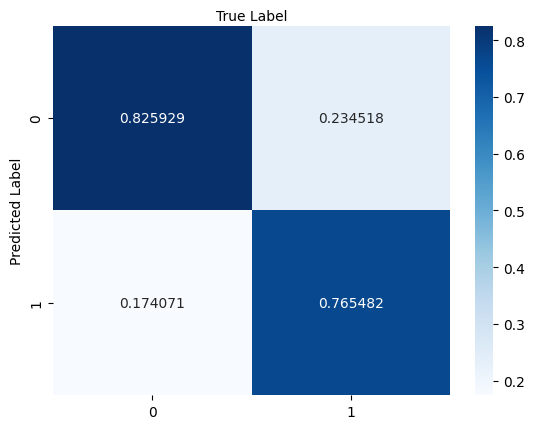

In [35]:
confusion_matrix(y_test, y_pred.round())

cm = confusion_matrix(y_test, y_pred.round()).T
cm = cm.astype('float')/cm.sum(axis=0)

fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, cmap='Blues',fmt='g');
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')
ax.xaxis.set_label_position('top')

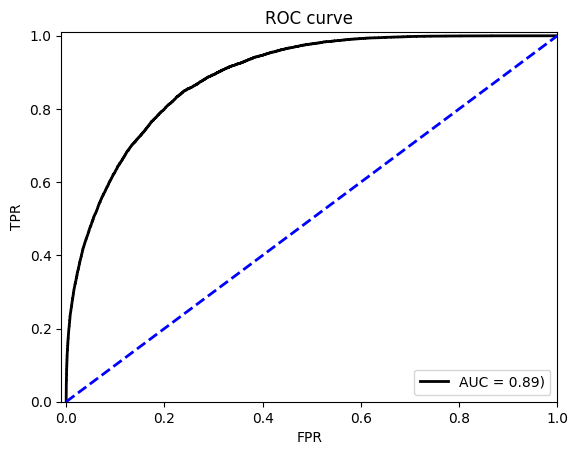

In [36]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='black',
lw=lw, label='AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='blue', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

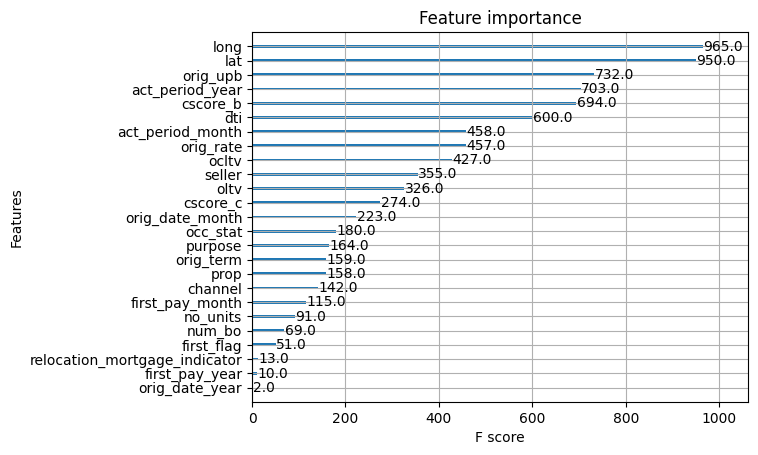

In [37]:
xgb.plot_importance(model)
plt.show()

In [38]:
model.save_model('default_predictor_xgb.json')

In [40]:
import pickle
with open("default_predictor_xgb.pkl", "wb") as file:
    pickle.dump(model, file)